<a href="https://colab.research.google.com/github/signumneo/Jacob_Profile/blob/main/Project3_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366532 sha256=86c50c39308557d89cc29286309d2e2675f83f3082d692ad16a49fa8d4e88fc2
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [3]:
#Import the necessary libraries and modules
import os
import csv
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection.validation  import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans

In [4]:
#Helper Function Definitions
def plot_histogram(ydata, x_labels = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], title = 'Generic Title', x_label= 'x_label', y_label='y_label'):
    x_val, freq = np.unique(ydata, return_counts=True)   
    plt.gcf().clear()
    fig, ax = plt.subplots(figsize=(12,9))
    x_ticks = np.arange(len(freq))
    ax.bar(x_ticks, freq, edgecolor='black', linewidth=2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_val)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()  

def plot_distribution(ydata,xdata=None, title='Generic Distribution', x_label='Generic', y_label='Generic'):
    plt.gcf().clear()
    if xdata is None:
        plt.plot(ydata)
    else:
        plt.plot(xdata,ydata) 
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show() 

In [ ]:
def popular_movies_filtered(testset, freq_movies):
    filtered = list(freq_movies.where(freq_movies >2).dropna().keys()) # keys are movieIds
    
    filtered_testset = []
    for i in range(len(testset)):
        if int(testset[i][1]) in filtered:
            filtered_testset.append(testset[i])
    return filtered_testset

def unpopular_movies_filtered(testset, freq_movies):
    filtered = list(freq_movies.where(freq_movies <=2).dropna().keys()) #keys are movieIds
           
    filtered_testset = []
    for i in range(len(testset)):
        if int(testset[i][1]) in filtered:
            filtered_testset.append(testset[i])
    return filtered_testset

def high_var_movies_filtered(testset, freq_movies, high_var_movies):
    filtered = list(freq_movies.where(freq_movies >=5).dropna().keys()) #keys are movieIds
    filtered_var = list(high_var_movies.where(high_var_movies >=2).dropna().keys()) #np.where(high_var_movies>=2)[0]
    
    filtered_testset = []
    for i in range(len(testset)):
        if int(testset[i][1]) in filtered and int(testset[i][1]) in filtered_var:
            filtered_testset.append(testset[i])
    return filtered_testset

def combined_roc_plotter(fprs, tprs, aucs, rt_th):
    plt.gcf().clear()
    plt.figure(figsize=(12,9))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC Curve', fontsize=23)
    for i in range(len(fprs)):
        plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=rt_th[i], auc=aucs[i]) )
    plt.legend(loc="lower right")
    plt.show()
    
def draw_precision_recall(y_axis, x_axis, y_axis_label, x_axis_label,title):
    plt.gcf().clear()
    plt.figure(figsize=(12,9))
    plt.scatter(x_axis,y_axis)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.show()

def round_to_half(n):
    return round(n * 2) / 2

In [5]:
Ratings = pd.read_csv('ratings.csv')

In [6]:
Ratings.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237


In [7]:
#Using relevant columns from the dataset
R_df = Ratings.pivot_table('rating', 'userId', 'movieId', fill_value=0)

In [8]:
R_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.5,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


## Q1 A. 
## Compute the sparsity of the movie rating dataset:
### Sparsity = Total number of available ratings/ Total number of possible ratings

In [9]:
total_available_rating = len(Ratings)
total_possible_ratings =np.prod(R_df.shape)

sparsity = total_available_rating / total_possible_ratings

print('Question 1: Sparsity =', sparsity)

Question 1: Sparsity = 0.016999683055613623


In [11]:
Ratings.rating.unique()

array([3. , 4. , 1.5, 4.5, 2.5, 2. , 1. , 3.5, 5. , 0.5])

## Q1 B. 
## Plot a histogram showing the frequency of the rating values: 
### Bin the raw rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R that fall within each bin and use this count as the height of the vertical axis for that particular bin. Comment on the shape of the histogram.

<Figure size 432x288 with 0 Axes>

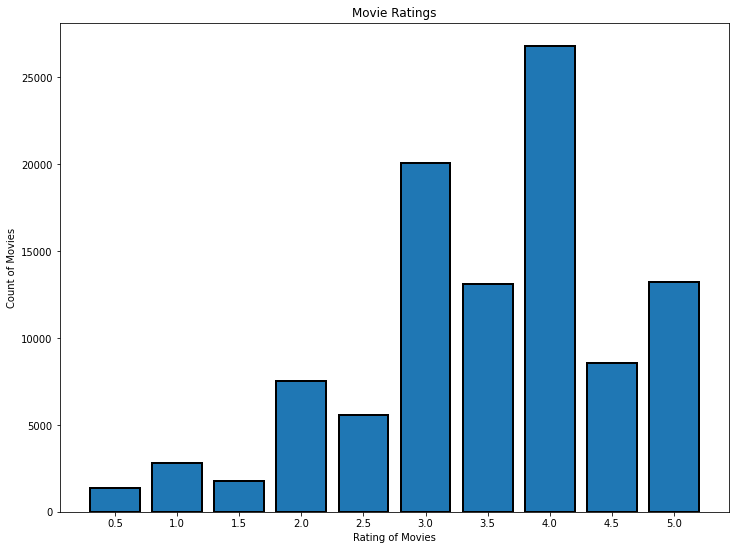

In [12]:
plot_histogram(ydata = Ratings.rating, title='Movie Ratings', x_label='Rating of Movies', y_label='Count of Movies')

In [14]:
frequency_movies = np.sum(R_df!=0, axis=0) #We need to do R_df!=0 to avoid considering users that do not give movie ratings
movie_sorted = frequency_movies.sort_values(ascending=False)

## Q1 C.
## Plot the distribution of the number of ratings received among movies: 
### The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend is expected.

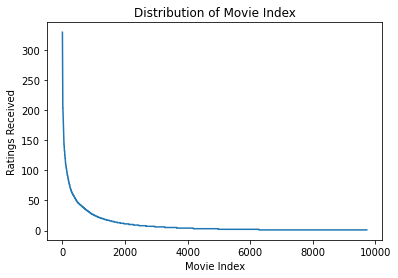

In [15]:
plot_distribution(ydata=list(movie_sorted), title='Distribution of Movie Index', x_label='Movie Index', y_label='Ratings Received')

In [17]:
frequency_users = np.sum(R_df!=0, axis=1) #We need to do R_df!=0 to avoid considering users that do not give movie ratings
user_sorted = frequency_users.sort_values(ascending=False)

## Q1 D.
## Plot the distribution of ratings among users: 
### The X-axis should be the user index ordered by decreasing frequency and the Y-axis should be the number of movies the user has rated. The requirement of the plot is similar to that in Question C.

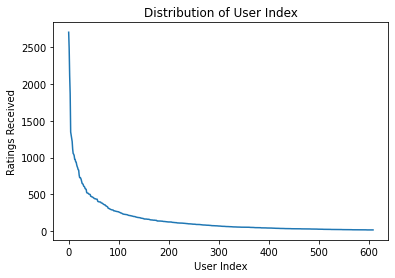

In [18]:
plot_distribution(ydata=list(user_sorted), title='Distribution of User Index', x_label='User Index', y_label='Ratings Received')

In [20]:
R_df_na = Ratings.pivot_table('rating', 'userId', 'movieId') #No rating is referred to as nan
var_movie = np.var(R_df_na,axis=0)

## Q1 E. 
## Discuss the salient features of the distributions
### from Questions C,D and their implications for the recommendation process.

### From figures C and D above, we can observe that the top few most rating frequencies occupy the most number of total ratings, which means few movies are popular, and rate by a great number of users. 
### For popular movies, many people rate on them, so it is easier for recommendation system to collect the ratings and predict precisely whether to recommend that movie to the user or not.


In [21]:
var_movie = [ round_to_half(elem) for elem in var_movie ]

## Q1 F.
## Compute the variance of the rating values received by each movie: 
### Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the resulting histogram.

<Figure size 432x288 with 0 Axes>

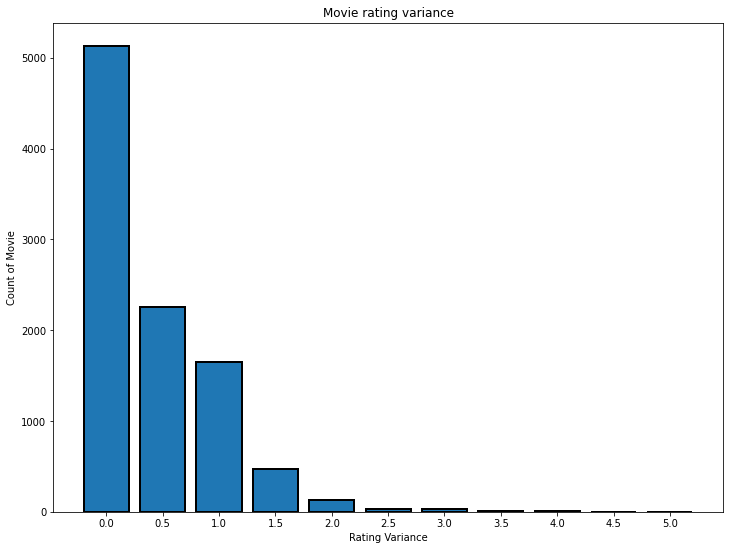

In [22]:
plot_histogram(ydata = var_movie, title="Movie rating variance", x_label="Rating Variance",y_label="Count of Movie" )

## Q2. 
## Understanding the Pearson Correlation Coefficient:`

## Q2 A. 
### Write down the formula for $μ_u$ in terms of $I_u$ and $r_{uk}$;

### The items u has rating on is the set of $𝐼u$, and rating for user u on item k is 𝑟uk. 
### The sum of total rating is $ \sum \limits _{k∈Iu} ruk$, and the frequency user u rate is $|I_u|$, so I have the following equation calculate the mean rating for user u.
## $μ_u = \frac {\sum \limits _{k∈Iu} r_{uk}}{|Iu|}$

## Q2 B. 
### In plain words, explain the meaning of $I_u ∩ I_v$. Can $I_u ∩ I_v = ∅$?
### (Hint: Rating matrix R is sparse)

### $I_u ∩ I_v$ is set of the item indices user u and user v share. 
### If user u and user v does not have any set of item indices share, then $I_u ∩ I_v = ∅$.

## Q3.

### Understanding the Prediction function: Can you explain the reason behind mean-centering the raw ratings $(r_{vj} − μ_v)$ in the prediction function? 
### (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)


### We would like to know how a movie to a user is, but for every user, the rating is different:
### if some people are stricter, they give all score low, so if we want to know if he/she likes the movie, we should compare to the person’s rating average. Therefore, we subtract the raw ratings by the person’s average $(𝑟_{vj} − μ_u)$, vice versa.

## Q4.

### Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. 
### Sweep $k$ (number of neighbors) from 2 to 100 in step sizes of 2, and for each $k$ compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against $k$ (X-axis).

In [27]:
#Input taken here
reader = Reader(rating_scale=(0.5, 5))
ratings_surprise_dataset = Dataset.load_from_df(Ratings[['userId','movieId','rating']], reader)

In [28]:
%%capture
RMSE = []
MAE = []
knn_ks = np.arange(2,102,2)

for k in range(2,102,2):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
    cv = cross_validate(knn, ratings_surprise_dataset, measures=['RMSE','MAE'],cv=10, verbose=False)
    RMSE.append(np.mean(cv['test_rmse']))
    MAE.append(np.mean(cv['test_mae']))    

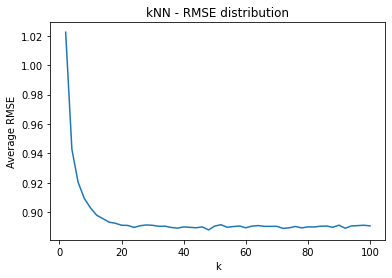

In [29]:
plot_distribution(RMSE, knn_ks, title="kNN - RMSE distribution", x_label="k", y_label="Average RMSE")

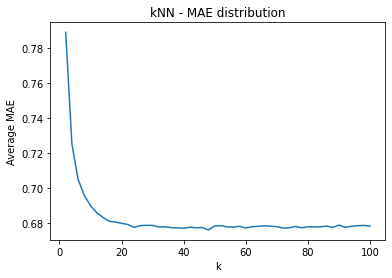

In [30]:
plot_distribution(MAE, knn_ks, title="kNN - MAE distribution", x_label="k", y_label="Average MAE")

## Q5.

### Use the plot from question 4, to find a 'minimum k'. Note: The term 'minimumk' in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. 
### If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. 
### Please report the steady state values of average RMSE and average MAE.

In [31]:
for k in range(1,len(RMSE)+1):
    if((abs(RMSE[k]-RMSE[k+1])<0.0001)):
        min_k = k*2
        print("Minimum k: ", min_k)
        print("Average RMSE at minimum k: ", RMSE[k])
        print("Average MAE at minimum k: ", MAE[k])
        break

Minimum k:  30
Average RMSE at minimum k:  0.8903203634178475
Average MAE at minimum k:  0.6776896999258473


## Q6.

## Within EACH of the 3 trimmed subsets in the dataset, design:

*  ### Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

* ### Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These thresholds are applied only on the training set. For each of the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds can be condensed into one plot per trimming option yielding only 4 plots.




In [32]:
from surprise.model_selection import KFold

In [33]:
kf = KFold(n_splits=10)
RMSE_pop_movies_filtered = []
for k in range(2,102,2):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset)
        knn.fit(trainset)
        filtered_testset = popular_movies_filtered(testset, frequency_movies)
        pred = knn.test(filtered_testset)
        temp_rsme.append(accuracy.rmse(pred, verbose=False)) #Compute RMSE
    RMSE_pop_movies_filtered.append(np.mean(temp_rsme))

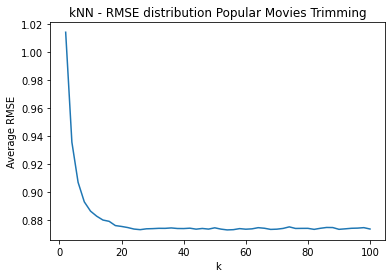

In [34]:
plot_distribution(RMSE_pop_movies_filtered,knn_ks, title="kNN - RMSE distribution Popular Movies Trimming", x_label="k", y_label="Average RMSE")

In [35]:
print(min(RMSE_pop_movies_filtered)) #Minimum RMSE

0.8728103290830422


In [36]:
kf = KFold(n_splits=10)
RMSE_unpop_movies_filtered = []
for k in range(2,102,2):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        knn.fit(trainset)
        filtered_testset = unpopular_movies_filtered(testset, frequency_movies)
        pred = knn.test(filtered_testset)
        temp_rsme.append(accuracy.rmse(pred, verbose=False))  #Compute RMSE
    RMSE_unpop_movies_filtered.append(np.mean(temp_rsme))

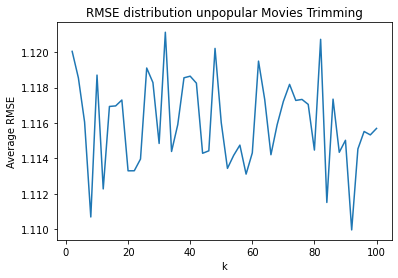

In [37]:
plot_distribution(RMSE_unpop_movies_filtered,knn_ks, title="RMSE distribution unpopular Movies Trimming", x_label="k", y_label="Average RMSE")

In [38]:
print(min(RMSE_unpop_movies_filtered))

1.109962885293225


In [39]:
kf = KFold(n_splits=10)
RMSE_high_var_movies_filtered = []
high_variance_movies = np.var(R_df_na, axis=0)
for k in range(2,102,2):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        knn.fit(trainset)
        filtered_testset = high_var_movies_filtered(testset, frequency_movies, high_variance_movies)
        pred = knn.test(filtered_testset)
        temp_rsme.append(accuracy.rmse(pred, verbose=False)) #Compute RMSE
    RMSE_high_var_movies_filtered.append(np.mean(temp_rsme))

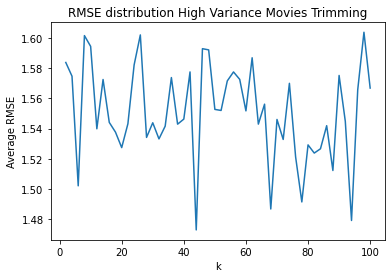

In [40]:
plot_distribution(RMSE_high_var_movies_filtered,knn_ks, title="RMSE distribution High Variance Movies Trimming", x_label="k", y_label="Average RMSE")

In [41]:
print(min(RMSE_high_var_movies_filtered))

1.472990057009533


In [42]:
ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    knn = KNNWithMeans(k=20, sim_options={'name': 'pearson'}) #Min_RSME 
    trainset, testset = train_test_split(ratings_surprise_dataset, test_size=0.1)
    knn.fit(trainset)
    pred = knn.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold: #Ratings threshold
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


<Figure size 432x288 with 0 Axes>

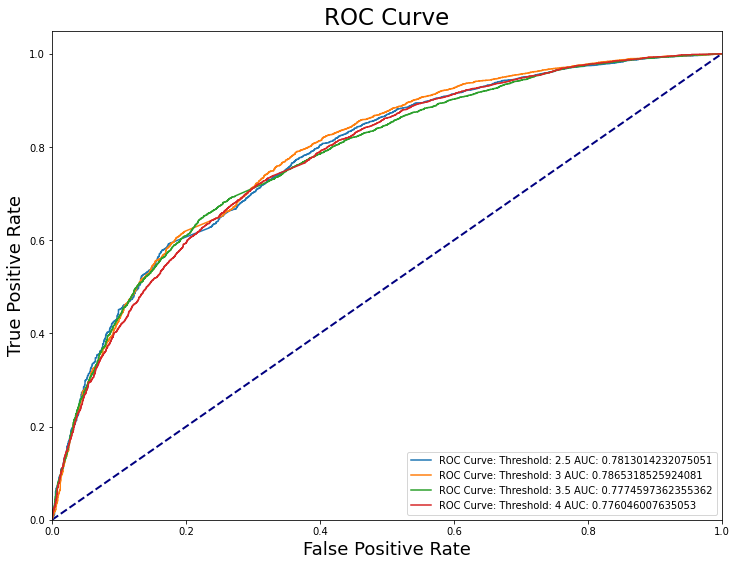

In [43]:
combined_roc_plotter(fprs,tprs,AUCs,ratings_thresholds)

In [46]:
# NMFs
nmf_ks = np.arange(2,52,2)
nmf_mae, nmf_rmse = [],[]
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=False)
    cv = cross_validate(nmf, ratings_surprise_dataset,measures=['RMSE','MAE'],cv=10, verbose=False)
    nmf_rmse.append(np.mean(cv['test_rmse']))
    nmf_mae.append(np.mean(cv['test_mae']))

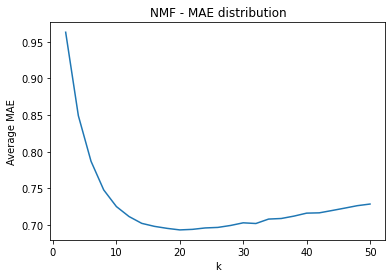

In [47]:
plot_distribution(nmf_mae, nmf_ks, title="NMF - MAE distribution", x_label="k", y_label="Average MAE")

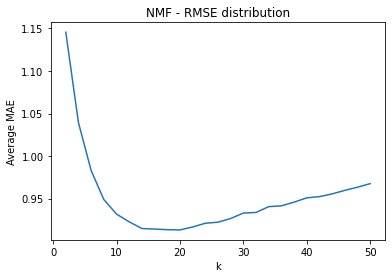

In [48]:
plot_distribution(nmf_rmse, nmf_ks, title="NMF - RMSE distribution", x_label="k", y_label="Average MAE")

In [49]:
# Question 18: Use the plot from question 17, to find the optimal number of
# latent factors. Optimal number of latent factors is the value of k that gives
# the minimum average RMSE or the minimum average MAE. Please report the
# minimum average RMSE and MAE. Is the optimal number of latent factors
# same as the number of movie genres?

In [51]:
Genres = pd.read_csv('movies.csv', delimiter=',')
genre_str = ''.join(Genres.genres)
genre_str = genre_str.split("|")
genre_str = ''.join(genre_str)
genre_str = re.findall('[A-Z][^A-Z]*', genre_str)

print("Number of movie genres: ", len(set(genre_str)))

Number of movie genres:  36


In [52]:
#position where min RMSE
nmf_min_RMSE = [i for i, x in enumerate(nmf_rmse) if x == min(nmf_rmse)]
print(min(nmf_rmse))
print(nmf_ks[nmf_min_RMSE]) #lowest k value

0.9131992982317323
[20]


In [53]:
#position where min MAE
nmf_min_MAE = [i for i, x in enumerate(nmf_mae) if x == min(nmf_mae)]
print(min(nmf_mae))
print(nmf_ks[nmf_min_MAE]) # lowest k value

0.6932890855454275
[20]


In [54]:
# Question 19: Design a NNMF collaborative filter to predict the ratings of the
# movies in the popular movie trimmed test set and evaluate it's performance us-
# ing 10-fold cross validation.Sweep k ( number of latent factors) from 2 to 50 in
# step sizes of 2, and for each k compute the average RMSE obtained by averaging
# the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
# Also, report the minimum average RMSE

In [55]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_pop_movies_filtered_nmf = []
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=False)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = popular_movies_filtered(testset, frequency_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_pop_movies_filtered_nmf.append(np.mean(temp_rsme))

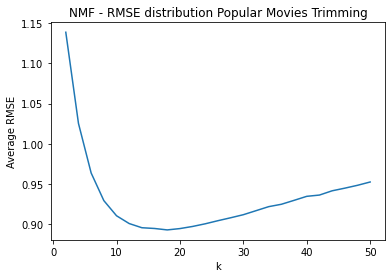

In [56]:
nmf_ks = np.arange(2,52,2)
plot_distribution(RMSE_pop_movies_filtered_nmf,nmf_ks, title="NMF - RMSE distribution Popular Movies Trimming", x_label="k", y_label="Average RMSE")


In [57]:
print(min(RMSE_pop_movies_filtered_nmf))

0.8927703421043575


In [58]:
# Question 20: Design a NNMF collaborative filter to predict the ratings of the
# movies in the unpopular movie trimmed test set and evaluate it's performance
# using 10-fold cross validation.Sweep k ( number of latent factors) from 2 to 50 in
# step sizes of 2, and for each k compute the average RMSE obtained by averaging
# the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
# Also, report the minimum average RMSE

In [59]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_unpop_movies_filtered_nmf = []
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=False)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = unpopular_movies_filtered(testset, frequency_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_unpop_movies_filtered_nmf.append(np.mean(temp_rsme))

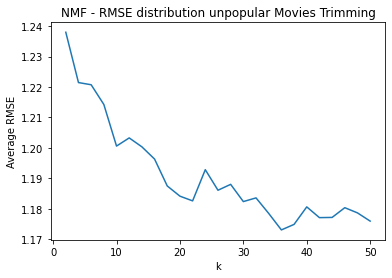

In [60]:
plot_distribution(RMSE_unpop_movies_filtered_nmf,nmf_ks, title="NMF - RMSE distribution unpopular Movies Trimming", x_label="k", y_label="Average RMSE")

In [61]:
print(min(RMSE_unpop_movies_filtered_nmf))

1.1730628657917777


In [62]:
# Question 21: Design a NNMF collaborative filter to predict the ratings of the
# movies in the high variance movie trimmed test set and evaluate it's perfor-
# mance using 10-fold cross validation.Sweep k ( number of latent factors) from 2
# to 50 in step sizes of 2, and for each k compute the average RMSE obtained by
# averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k
# (X-axis). Also, report the minimum average RMSE

In [63]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_high_var_movies_filtered_nmf = []
high_variance_movies = np.var(R_df_na, axis=0)
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=False)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = high_var_movies_filtered(testset, frequency_movies, high_variance_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_high_var_movies_filtered_nmf.append(np.mean(temp_rsme))

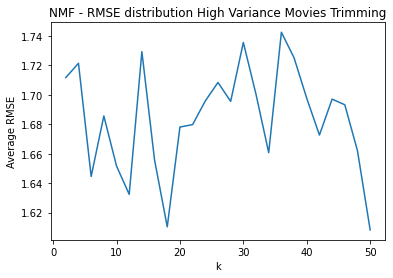

In [64]:
plot_distribution(RMSE_high_var_movies_filtered_nmf,nmf_ks, title="NMF - RMSE distribution High Variance Movies Trimming", x_label="k", y_label="Average RMSE")

In [65]:
print(min(RMSE_high_var_movies_filtered_nmf))
print(RMSE_high_var_movies_filtered_nmf[18])

1.6081710824921267
1.725205682853381


In [66]:
# Question 22: Plot the ROC curves for the NNMF-based collaborative filter
# designed in question 17 for threshold values [2:5; 3; 3:5; 4]. For the ROC plot-
# ting use the optimal number of latent factors found in question 18. For each of
# the plots, also report the area under the curve (AUC) value.

In [67]:
ratings_thresholds = [2.5,3,3.5,4]

nmf_fprs = []
nmf_tprs = []
nmf_AUCs = []

# min k is 16
for threshold in ratings_thresholds:
    nmf = NMF(n_factors=16, biased=False) #min_RSME is from problem 11.
    trainset, testset = train_test_split(ratings_surprise_dataset, test_size=0.1)
    nmf.fit(trainset)
    pred = nmf.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold: #ratings threshold
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    nmf_fprs.append(fpr)
    nmf_tprs.append(tpr)
    nmf_AUCs.append(AUC)

<Figure size 432x288 with 0 Axes>

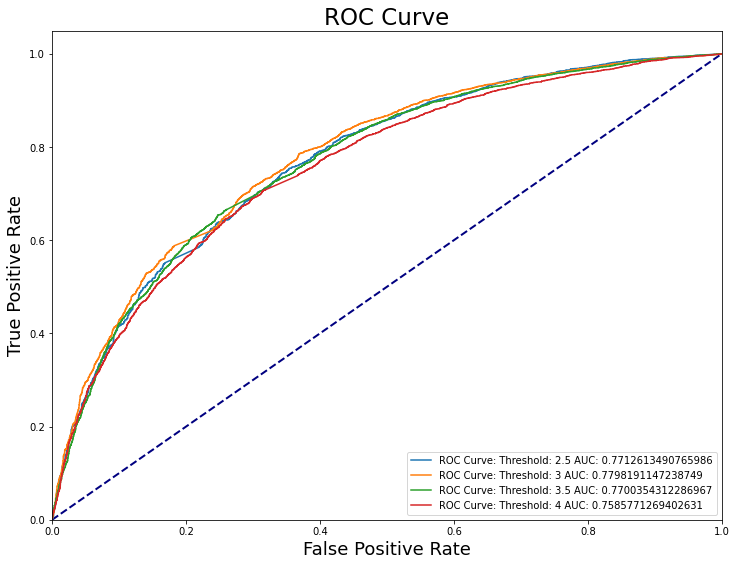

In [68]:
combined_roc_plotter(nmf_fprs,nmf_tprs,nmf_AUCs,ratings_thresholds)

In [69]:
# Question 23: Perform Non-negative matrix factorization on the ratings matrix
# R to obtain the factor matrices U and V , where U represents the user-latent
# factors interaction and V represents the movie-latent factors interaction (use k
# = 20). For each column of V , sort the movies in descending order and report
# the genres of the top 10 movies. Do the top 10 movies belong to a particular
# or a small collection of genre? Is there a connection between the latent factors
# and the movie genres?

In [71]:
with open('movies.csv', 'r', encoding='utf8') as f:
    reader = csv.reader(f, delimiter=',', quotechar='"')
    next(reader, None)
    movies = {int(movie[0]): movie[2] for movie in reader}
  
reader = Reader(sep=',', rating_scale=(0.0, 5.0), skip_lines=1)
allMovies = Dataset.load_from_file('ratings.csv', reader=reader)

In [72]:
k, col = 20, 20

In [73]:
nmf = NMF(n_factors=k)
train_all_movies = allMovies.build_full_trainset()

In [74]:
nmf.fit(train_all_movies)

In [77]:
item_factors = nmf.qi
for c in range(col):
    print("Top 10 Values in Column")
    sort_indices = np.argsort(-1*item_factors[:,c])[0:10]
    print(item_factors[sort_indices[0:10],c])
    print("Genres of Corresponding Movies:")
    #for i in sort_indices:
        #print(movies[int(train_all_movies.to_raw_iid(i))])
    #print("")

Top 10 Values in Column
[1.5243733  1.40495431 1.40260347 1.32188261 1.24695331 1.24321775
 1.24073371 1.22622542 1.21850092 1.21645773]
Genres of Corresponding Movies:
Top 10 Values in Column
[1.63345134 1.42187097 1.33381367 1.3233399  1.31863028 1.29767929
 1.28682491 1.25734721 1.25142801 1.24225104]
Genres of Corresponding Movies:
Top 10 Values in Column
[1.41188988 1.38582532 1.31051037 1.30830702 1.3079382  1.28401439
 1.28221148 1.2688534  1.25759267 1.24671117]
Genres of Corresponding Movies:
Top 10 Values in Column
[1.42746772 1.379492   1.3787752  1.2933121  1.29181674 1.25414558
 1.24944305 1.23607527 1.2327266  1.22490106]
Genres of Corresponding Movies:
Top 10 Values in Column
[1.32106972 1.28683232 1.26419984 1.25324417 1.25119962 1.24926034
 1.23109599 1.22651538 1.22134218 1.21638303]
Genres of Corresponding Movies:
Top 10 Values in Column
[1.31961225 1.31682678 1.30282846 1.26967425 1.24724298 1.23274398
 1.22508419 1.21651824 1.21518073 1.21026532]
Genres of Correspo

In [78]:
# Question 24: Design a MF with bias collaborative filter to predict the ratings of
# the movies in the MovieLens dataset and evaluate it's performance using 10-fold
# cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes
# of 2, and for each k compute the average RMSE and average MAE obtained
# by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE
# (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
# For solving this question, use the default value for the regularization parameter.

In [79]:
# NMFs
nmf_ks = np.arange(2,52,2)
nmf_mae_baised, nmf_rmse_biased = [],[]
for k in range(2,52,2):
    nmf = SVD(n_factors=k, biased=True)
    cv = cross_validate(nmf, ratings_surprise_dataset,measures=['RMSE','MAE'],cv=10, verbose=False)
    nmf_rmse_biased.append(np.mean(cv['test_rmse']))
    nmf_mae_baised.append(np.mean(cv['test_mae']))

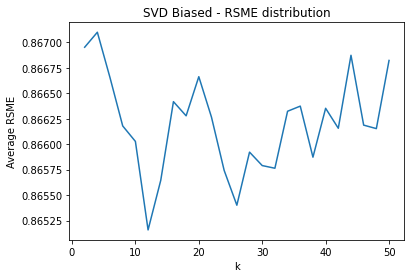

In [80]:
plot_distribution(nmf_rmse_biased, nmf_ks, title="SVD Biased - RSME distribution", x_label="k", y_label="Average RSME")

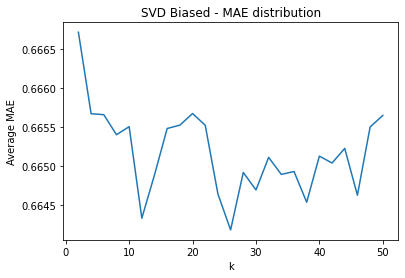

In [81]:
plot_distribution(nmf_mae_baised, nmf_ks, title="SVD Biased - MAE distribution", x_label="k", y_label="Average MAE")

In [82]:
# Question 25: Use the plot from question 24, to find the optimal number of
# latent factors. Optimal number of latent factors is the value of k that gives
# the minimum average RMSE or the minimum average MAE. Please report the
# minimum average RMSE and MAE.

In [83]:
# Question 26: Design a MF with bias collaborative filter to predict the ratings of
# the movies in the popular movie trimmed test set and evaluate it's performance
# using 10-fold cross validation.Sweep k ( number of latent factors) from 2 to 50 in
# step sizes of 2, and for each k compute the average RMSE obtained by averaging
# the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
# Also, report the minimum average RMSE

In [84]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_pop_movies_filtered_nmf_baised = []
for k in range(2,52,2):
    nmf = SVD(n_factors=k, biased=True)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = popular_movies_filtered(testset, frequency_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_pop_movies_filtered_nmf_baised.append(np.mean(temp_rsme))

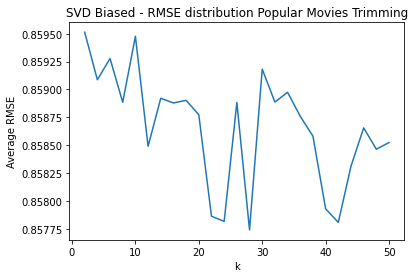

In [85]:
nmf_ks = np.arange(2,52,2)
plot_distribution(RMSE_pop_movies_filtered_nmf_baised,nmf_ks, title="SVD Biased - RMSE distribution Popular Movies Trimming", x_label="k", y_label="Average RMSE")

In [86]:
print(min(RMSE_pop_movies_filtered_nmf_baised))

0.8577408013982784


In [87]:
# Question 27: Design a MF with bias collaborative filter to predict the rat-
# ings of the movies in the unpopular movie trimmed test set and evaluate it's
# performance using 10-fold cross validation.Sweep k ( number of latent factors)
# from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob-
# tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis)
# against k (X-axis). Also, report the minimum average RMSE

In [88]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_unpop_movies_filtered_nmf_biased = []
for k in range(2,52,2):
    nmf = SVD(n_factors=k, biased=True)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = unpopular_movies_filtered(testset, frequency_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_unpop_movies_filtered_nmf_biased.append(np.mean(temp_rsme))
    

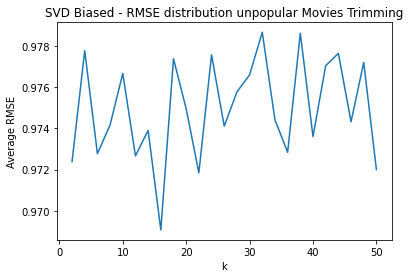

In [89]:
plot_distribution(RMSE_unpop_movies_filtered_nmf_biased,nmf_ks, title="SVD Biased - RMSE distribution unpopular Movies Trimming", x_label="k", y_label="Average RMSE")

In [90]:
print(min(RMSE_unpop_movies_filtered_nmf_biased))

0.9690694125217204


In [91]:
# Question 28: Design a MF with bias collaborative filter to predict the rat-
# ings of the movies in the high variance movie trimmed test set and evaluate it's
# performance using 10-fold cross validation.Sweep k ( number of latent factors)
# from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob-
# tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis)
# against k (X-axis). Also, report the minimum average RMSE

In [92]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_high_var_movies_filtered_nmf_biased = []
high_variance_movies = np.var(R_df_na, axis=0)
for k in range(2,52,2):
    nmf = SVD(n_factors=k, biased=True)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = high_var_movies_filtered(testset, frequency_movies, high_variance_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_high_var_movies_filtered_nmf_biased.append(np.mean(temp_rsme))

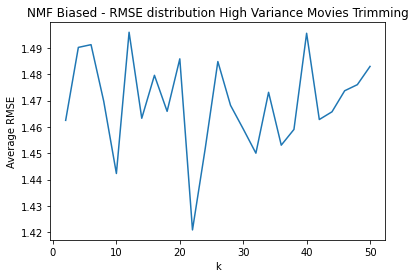

In [93]:
plot_distribution(RMSE_high_var_movies_filtered_nmf_biased,nmf_ks, title="NMF Biased - RMSE distribution High Variance Movies Trimming", x_label="k", y_label="Average RMSE")

In [94]:
print(min(RMSE_high_var_movies_filtered_nmf_biased))

1.4208865097622596


In [95]:
# Question 29: Plot the ROC curves for the MF with bias collaborative filter
# designed in question 24 for threshold values [2:5; 3; 3:5; 4]. For the ROC plot-
# ting use the optimal number of latent factors found in question 25. For each of
# the plots, also report the area under the curve (AUC) value.

In [96]:
ratings_thresholds = [2.5,3,3.5,4]

nmf_fprs = []
nmf_tprs = []
nmf_AUCs = []

# min k = 10
for threshold in ratings_thresholds:
    nmf = SVD(n_factors=14, biased=True)
    trainset, testset = train_test_split(ratings_surprise_dataset, test_size=0.1)
    nmf.fit(trainset)
    pred = nmf.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold: #ratings threshold
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    nmf_fprs.append(fpr)
    nmf_tprs.append(tpr)
    nmf_AUCs.append(AUC)

<Figure size 432x288 with 0 Axes>

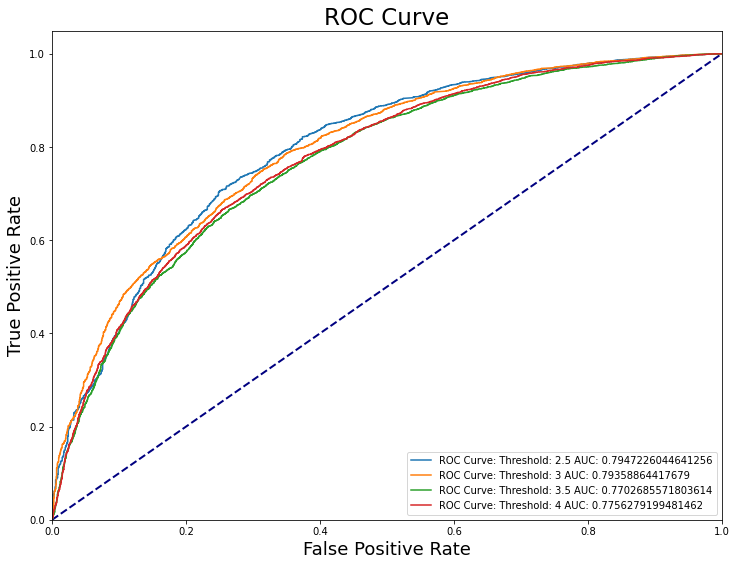

In [97]:
combined_roc_plotter(nmf_fprs,nmf_tprs,nmf_AUCs,ratings_thresholds)

In [98]:
# Question 30: Design a naive collaborative filter to predict the ratings of the
# movies in the MovieLens dataset and evaluate it's performance using 10-fold
# cross validation. Compute the average RMSE by averaging the RMSE across
# all 10 folds. Report the average RMSE.

In [99]:
from surprise import AlgoBase

# follow this example
#http://surprise.readthedocs.io/en/stable/building_custom_algo.html#when-the-prediction-is-impossible

class NaiveFilter(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)
        
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        
        # might not need to return the whole trainset
        # TODO: need to refactor this.
        self.trainset = trainset
        self.the_means = {}
        # ur is user rating
        # http://surprise.readthedocs.io/en/stable/trainset.html?highlight=.ur
        for key in self.trainset.ur:
            urs = self.trainset.ur[key]
            mean = np.mean([r for (_, r) in urs])
            self.the_means[key] = mean
        
        return self
    
    def estimate(self, u, i):
        if self.the_means.__contains__(u):
            return self.the_means[u]
        else:
            return 0
            
# class NaiveFilter(AlgoBase):

#     def __init__(self):
#         AlgoBase.__init__(self)
        
#     def fit(self, trainset):
#         AlgoBase.fit(self, trainset)    

#     def estimate(self, u, i):
        
#         sum_means = self.trainset.global_mean
#         div = 1
        
#         if self.trainset.knows_user(u):
#             sum_means += np.mean([r for (_, r) in self.trainset.ur[u]])
#         if self.trainset.knows_item(i):
#             sum_means += np.mean([r for (_, r) in self.trainset.ir[i]])
            
#         return sum_means / div            
            
            

In [100]:
naive_data = R_df_na.copy()
mean_ratings = naive_data.mean(axis=1)
for i in np.arange(1,len(mean_ratings)+1):
    naive_data.loc[i, :] = mean_ratings[i]

In [101]:
# NMFs
# nf_ks = np.arange(2,52,2)

nf_mae_baised, nf_rmse_biased = [],[]

nf = NaiveFilter()
cv = cross_validate(nf, ratings_surprise_dataset,measures=['RMSE','MAE'],cv=10, verbose=False)
nf_rmse_biased.append(np.mean(cv['test_rmse']))
nf_mae_baised.append(np.mean(cv['test_mae']))

In [102]:
print('average RMSE: ', nf_rmse_biased)
print('average MAE: ', nf_mae_baised)

average RMSE:  [0.9412188483845176]
average MAE:  [0.733825250748541]


In [103]:
# Question 31: Design a naive collaborative filter to predict the ratings of the
# movies in the popular movie trimmed test set and evaluate it's performance
# using 10-fold cross validation. Compute the average RMSE by averaging the
# RMSE across all 10 folds. Report the average RMSE.

In [104]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_pop_movies_filtered_nf_baised = []
nf = NaiveFilter()
temp_rsme = []

for trainset, testset in kf.split(ratings_surprise_dataset):
    #train and test
    nf.fit(trainset)
    filtered_testset = popular_movies_filtered(testset, frequency_movies)
    pred = nf.test(filtered_testset)
    #compute RMSE
    temp_rsme.append(accuracy.rmse(pred, verbose=False))
RMSE_pop_movies_filtered_nf_baised.append(np.mean(temp_rsme))


In [105]:
print('Average RMSE popular movies:', RMSE_pop_movies_filtered_nf_baised)

Average RMSE popular movies: [0.938808833720125]


In [106]:
# Question 32: Design a naive collaborative filter to predict the ratings of the
# movies in the unpopular movie trimmed test set and evaluate it's performance
# using 10-fold cross validation. Compute the average RMSE by averaging the
# RMSE across all 10 folds. Report the average RMSE.

In [107]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_unpop_movies_filtered_nf_biased = []

nf = NaiveFilter()
temp_rsme = []
for trainset, testset in kf.split(ratings_surprise_dataset):
    #train and test
    nf.fit(trainset)
    filtered_testset = unpopular_movies_filtered(testset, frequency_movies)
    pred = nf.test(filtered_testset)
    #compute RMSE
    temp_rsme.append(accuracy.rmse(pred, verbose=False))
RMSE_unpop_movies_filtered_nf_biased.append(np.mean(temp_rsme))

In [108]:
print('Average RMSE unpopular movies:', RMSE_unpop_movies_filtered_nf_biased)

Average RMSE unpopular movies: [0.9740378535307379]


In [109]:
# Question 33: Design a naive collaborative filter to predict the ratings of the
# movies in the high variance movie trimmed test set and evaluate it's perfor-
# mance using 10-fold cross validation. Compute the average RMSE by averaging
# the RMSE across all 10 folds. Report the average RMSE.

In [110]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_high_var_movies_filtered_nf_biased = []
high_variance_movies = np.var(R_df_na, axis=0)

nf = NaiveFilter()
temp_rsme = []

for trainset, testset in kf.split(ratings_surprise_dataset):
    #train and test
    nf.fit(trainset)
    filtered_testset = high_var_movies_filtered(testset, frequency_movies, high_variance_movies)
    pred = nf.test(filtered_testset)
    #compute RMSE
    temp_rsme.append(accuracy.rmse(pred, verbose=False))
RMSE_high_var_movies_filtered_nf_biased.append(np.mean(temp_rsme))

In [111]:
print('Average RMSE high variance movies:', RMSE_high_var_movies_filtered_nf_biased)

Average RMSE high variance movies: [1.4729195697161488]


In [112]:
# Question 34: Plot the ROC curves (threshold = 3) for the k-NN, NNMF, and
# MF with bias based collaborative filters in the same figure. Use the figure to
# compare the performance of the filters in predicting the ratings of the movies.

In [113]:
threshold = 3

compare_fprs = []
compare_tprs = []
compare_AUCs = []

trainset, testset = train_test_split(ratings_surprise_dataset, test_size=0.1)

#knn
knn = KNNWithMeans(k=20, sim_options={'name': 'pearson'})
knn.fit(trainset)
knn_pred = knn.test(testset)

    
real_y = []
est_y = []
for i in range(len(knn_pred)):
    est_y.append(knn_pred[i].est)
    if testset[i][2] >= threshold: #ratings threshold
        real_y.append(1.0)
    else:
        real_y.append(0.0)
            
fpr, tpr, thresholds = roc_curve(real_y, est_y)
AUC = roc_auc_score(real_y, est_y)
compare_fprs.append(fpr)
compare_tprs.append(tpr)
compare_AUCs.append(AUC)

#NMF baised = False
nmf = NMF(n_factors=16, biased=False)
nmf.fit(trainset)
nmf_pred = nmf.test(testset)

real_y = []
est_y = []
for i in range(len(nmf_pred)):
    est_y.append(nmf_pred[i].est)
    if testset[i][2] >= threshold: #ratings threshold
        real_y.append(1.0)
    else:
        real_y.append(0.0)
        
fpr, tpr, thresholds = roc_curve(real_y, est_y)
AUC = roc_auc_score(real_y, est_y)
compare_fprs.append(fpr)
compare_tprs.append(tpr)
compare_AUCs.append(AUC)


#NMF baised = true
nmf_biased = SVD(n_factors=13, biased=True)
nmf_biased.fit(trainset)
nmf_biased_pred = nmf_biased.test(testset)

real_y = []
est_y = []
for i in range(len(nmf_biased_pred)):
    est_y.append(nmf_biased_pred[i].est)
    if testset[i][2] >= threshold: #ratings threshold
        real_y.append(1.0)
    else:
        real_y.append(0.0)

fpr, tpr, thresholds = roc_curve(real_y, est_y)
AUC = roc_auc_score(real_y, est_y)
compare_fprs.append(fpr)
compare_tprs.append(tpr)
compare_AUCs.append(AUC)

Computing the pearson similarity matrix...
Done computing similarity matrix.


<Figure size 432x288 with 0 Axes>

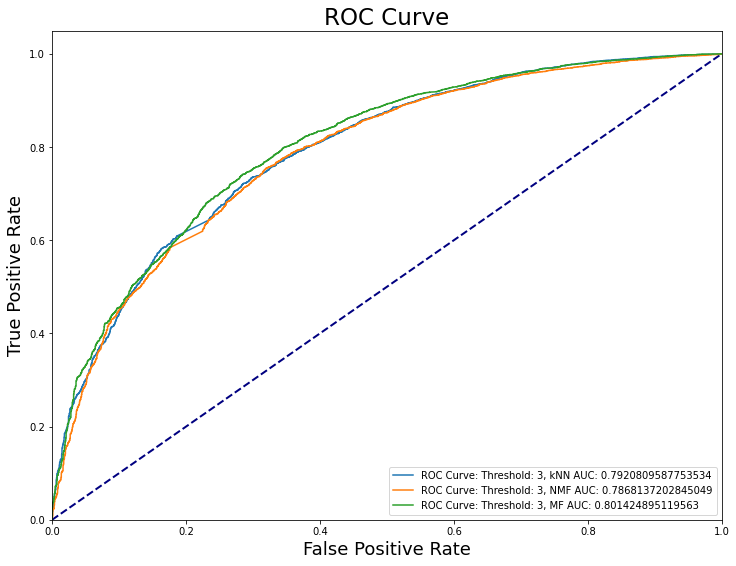

In [114]:
models = ['3, kNN', '3, NMF', '3, MF']
combined_roc_plotter(compare_fprs, compare_tprs, compare_AUCs, models)

In [115]:
# Question 35: Precision and Recall are defined by the mathematical expres-
# sions given by equations 12 and 13 respectively. Please explain the meaning of
# precision and recall in your own words.

In [116]:
# Question 36: Plot average precision (Y-axis) against t (X-axis) for the rank-
# ing obtained using k-NN collaborative filter predictions. Also, plot the average
# recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average
# recall (X-axis). Use the k found in question 11 and sweep t from 1 to 25 in step
# sizes of 1. For each plot, brie
# y comment on the shape of the plot.

In [117]:
def precision_recall(predictions, t, threshold=3):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = {}
    recalls = {}
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of recommended items
        n_rec_k = t
        
        # Number of relevant and recommended items in top t
        n_rel_and_rec_k = 0
        for i in range(t):
            if user_ratings[i][1] >= threshold:
                n_rel_and_rec_k += 1
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Precision
        precisions[uid] = n_rel_and_rec_k / n_rec_k

        # Recall
        recalls[uid] = n_rel_and_rec_k / n_rel

    return precisions, recalls

In [118]:
def testset_trim(testset, t, threshold=3):
    count = {}
    likes = {}
    
    for (u, i, r) in testset:
        if u not in count:
            count[u] = 0
        count[u] += 1
        if u not in likes:
            likes[u] = 0
        if r >= threshold:
            likes[u] += 1
            
    res = []
    for (u, i, r) in testset:
        if count[u] >= t and likes[u] > 0:
            res.append((u, i, r))
    
    return res

In [119]:
min_k_knn = 20 #knn_ks[min_knn_MAE][0]
min_k_nmf = 16 #nmf_ks[nmf_min_RMSE][0]
min_k_nmf_biased = 13 #nmf_ks[nmf_min_RMSE_biased][0]

In [120]:
%%capture

threshold = 3
ts = [i for i in range(1, 25 + 1)]

knn_precision = []
knn_recall = []

for t in ts:
    temp_prec = []
    temp_recall = []

    for trainset, testset in kf.split(ratings_surprise_dataset):
        knn = KNNWithMeans(k=min_k_knn, sim_options={'name': 'pearson'})
        knn.fit(trainset)
        trimmed_testset = testset_trim(testset, t)
        pred = knn.test(trimmed_testset)
    
        precisions, recalls = precision_recall(pred, t)
        fold_mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        fold_mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
            
        temp_prec.append(fold_mean_prec)
        temp_recall.append(fold_mean_recall)
    
    t_mean_prec = sum(prec for prec in temp_prec) / len(temp_prec)
    t_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    knn_precision.append(t_mean_prec)
    knn_recall.append(t_mean_recall)    

<Figure size 432x288 with 0 Axes>

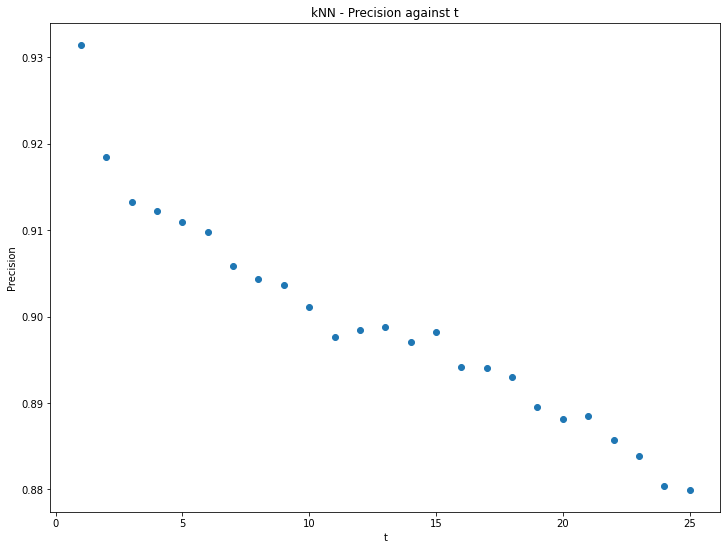

In [121]:
draw_precision_recall(knn_precision, ts, 'Precision', 't','kNN - Precision against t')

<Figure size 432x288 with 0 Axes>

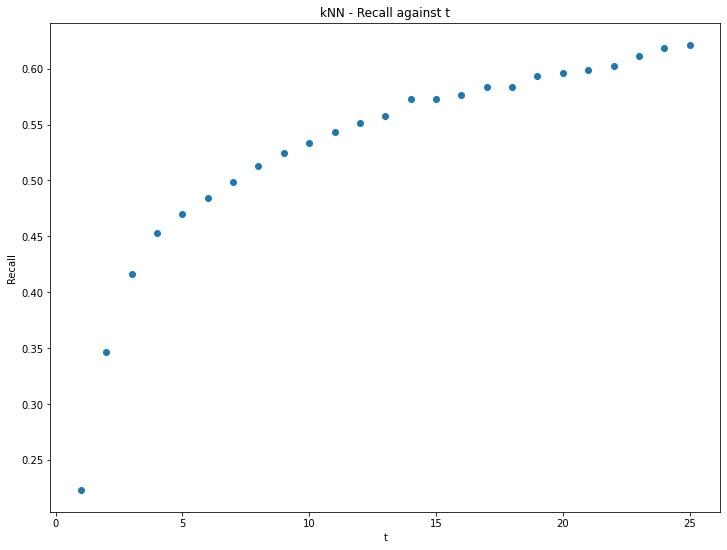

In [122]:
draw_precision_recall(knn_recall, ts, 'Recall', 't','kNN - Recall against t')

<Figure size 432x288 with 0 Axes>

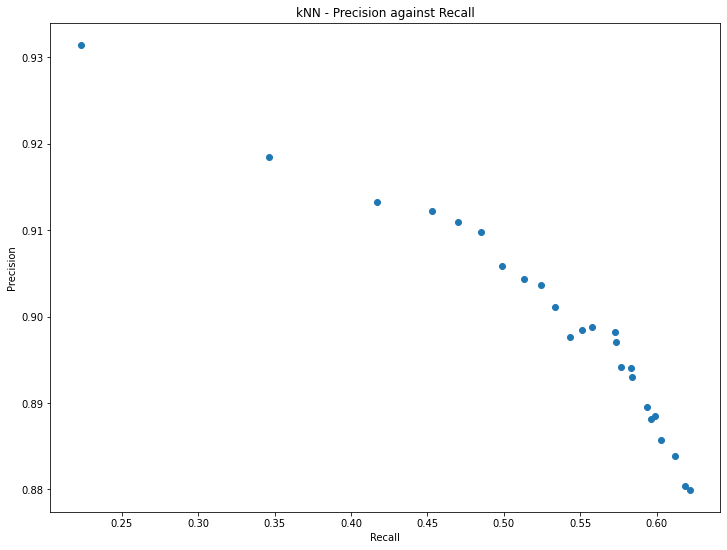

In [123]:
draw_precision_recall(knn_precision, knn_recall, 'Precision', 'Recall','kNN - Precision against Recall')

In [124]:
# Question 37: Plot average precision (Y-axis) against t (X-axis) for the rank-
# ing obtained using NNMF-based collaborative filter predictions. Also, plot the
# average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against
# average recall (X-axis). Use optimal number of latent factors found in question
# 18 and sweep t from 1 to 25 in step sizes of 1. For each plot, brie
# y comment
# on the shape of the plot.

In [125]:
nmf_precision = []
nmf_recall = []

for t in ts:
    temp_prec = []
    temp_recall = []

    for trainset, testset in kf.split(ratings_surprise_dataset):
        nmf = NMF(n_factors=min_k_nmf, biased=False)
        nmf.fit(trainset)
        trimmed_testset = testset_trim(testset, t)
        pred = nmf.test(trimmed_testset)
    
        precisions, recalls = precision_recall(pred, t)
        fold_mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        fold_mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
            
        temp_prec.append(fold_mean_prec)
        temp_recall.append(fold_mean_recall)
    
    t_mean_prec = sum(prec for prec in temp_prec) / len(temp_prec)
    t_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    nmf_precision.append(t_mean_prec)
    nmf_recall.append(t_mean_recall)

<Figure size 432x288 with 0 Axes>

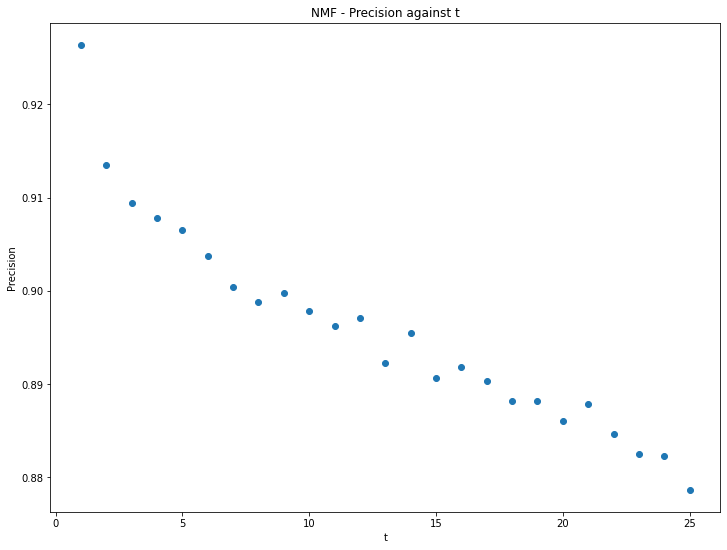

In [126]:
draw_precision_recall(nmf_precision, ts, 'Precision', 't','NMF - Precision against t')

<Figure size 432x288 with 0 Axes>

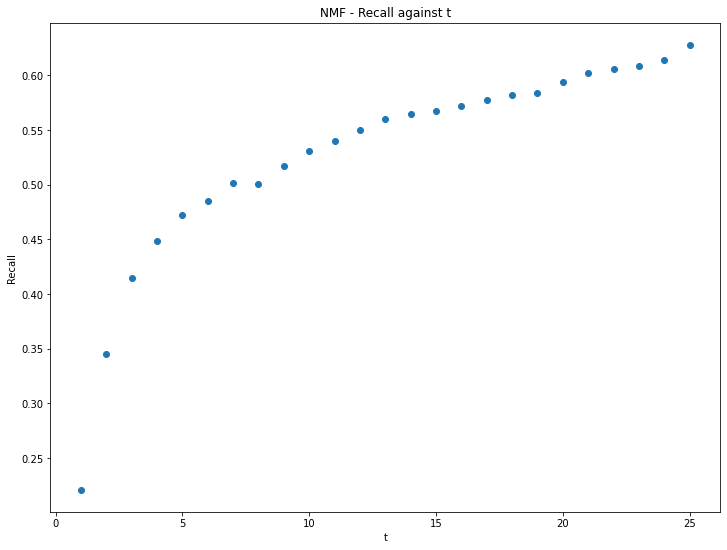

In [127]:
draw_precision_recall(nmf_recall, ts, 'Recall', 't','NMF - Recall against t')

<Figure size 432x288 with 0 Axes>

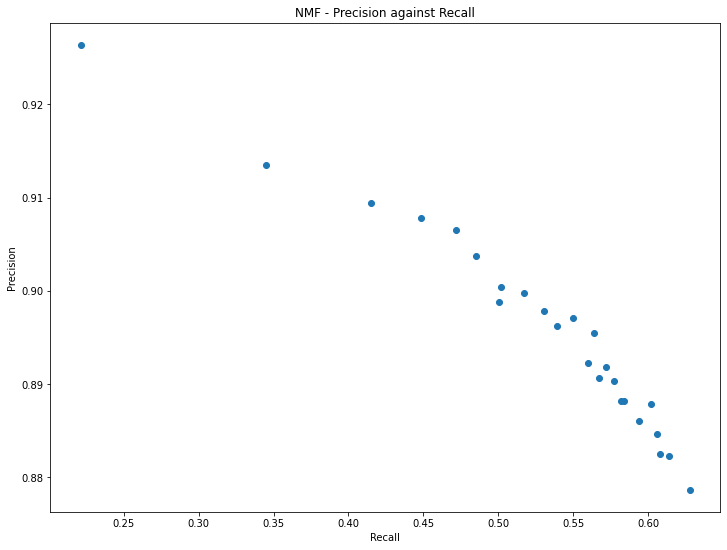

In [128]:
draw_precision_recall(nmf_precision, nmf_recall, 'Precision', 'Recall','NMF - Precision against Recall')

In [129]:
# Question 38: Plot average precision (Y-axis) against t (X-axis) for the ranking
# obtained using MF with bias-based collaborative filter predictions. Also, plot
# the average recall (Y-axis) against t (X-axis) and average precision (Y-axis)
# against average recall (X-axis). Use optimal number of latent factors found in
# question 25 and sweep t from 1 to 25 in step sizes of 1. For each plot, brie
# y
# comment on the shape of the plot.

In [130]:
nmf_biased_precision = []
nmf_biased_recall = []

for t in ts:
    temp_prec = []
    temp_recall = []

    for trainset, testset in kf.split(ratings_surprise_dataset):
        nmf = SVD(n_factors=min_k_nmf, biased=True)
        nmf.fit(trainset)
        trimmed_testset = testset_trim(testset, t)
        pred = nmf.test(trimmed_testset)
    
        precisions, recalls = precision_recall(pred, t)
        fold_mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        fold_mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
            
        temp_prec.append(fold_mean_prec)
        temp_recall.append(fold_mean_recall)
    
    t_mean_prec = sum(prec for prec in temp_prec) / len(temp_prec)
    t_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    nmf_biased_precision.append(t_mean_prec)
    nmf_biased_recall.append(t_mean_recall)

<Figure size 432x288 with 0 Axes>

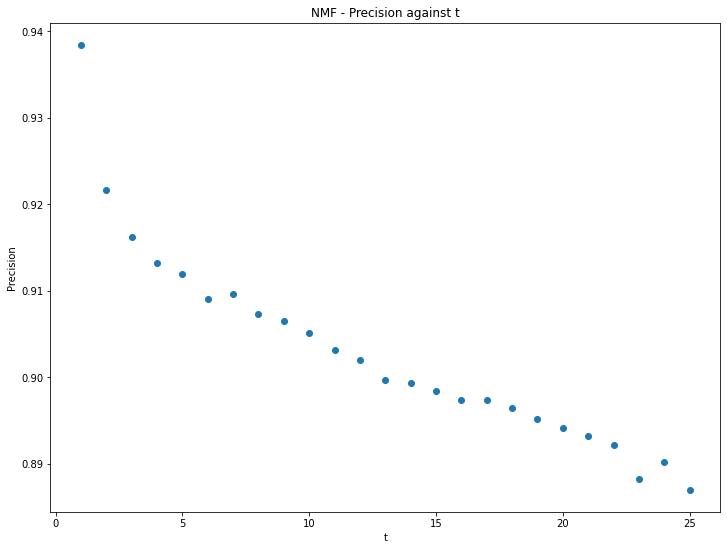

In [131]:
draw_precision_recall(nmf_biased_precision, ts, 'Precision', 't','NMF - Precision against t')

<Figure size 432x288 with 0 Axes>

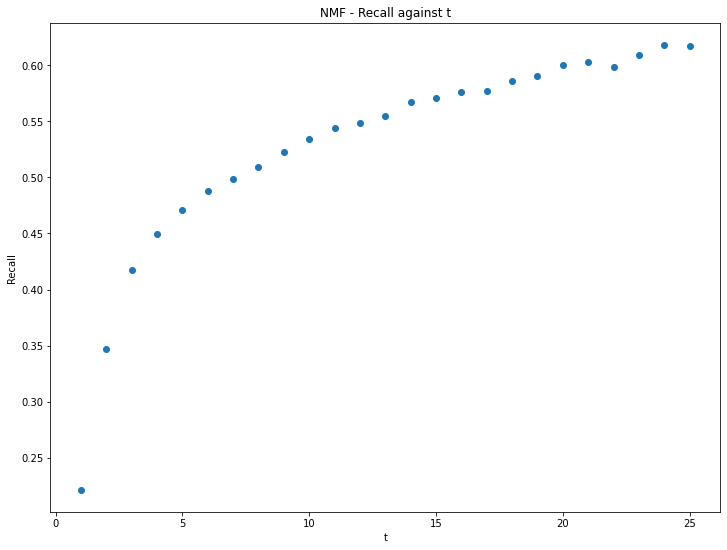

In [132]:
draw_precision_recall(nmf_biased_recall, ts, 'Recall', 't','NMF - Recall against t')

<Figure size 432x288 with 0 Axes>

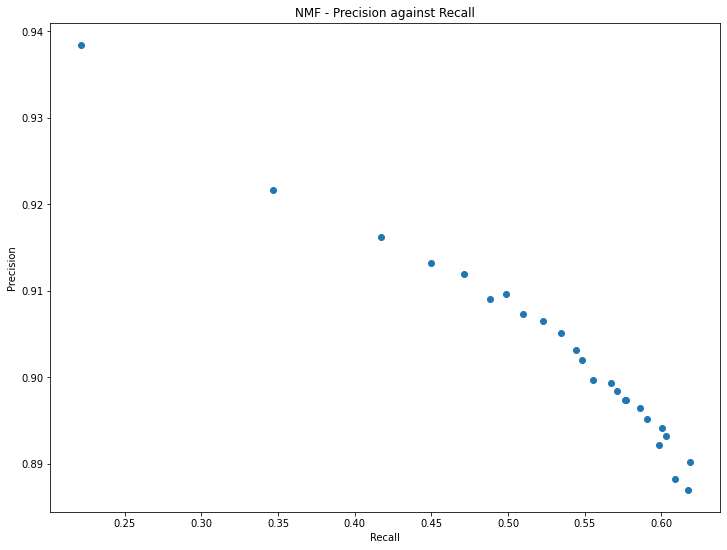

In [133]:
draw_precision_recall(nmf_biased_precision, nmf_biased_recall, 'Precision', 'Recall','NMF - Precision against Recall')

In [134]:
# Question 39: Plot the precision-recall curve obtained in questions 36,37, and
# 38 in the same figure. Use this figure to compare the relevance of the recom-
# mendation list generated using k-NN, NNMF, and MF with bias predictions.

<Figure size 432x288 with 0 Axes>

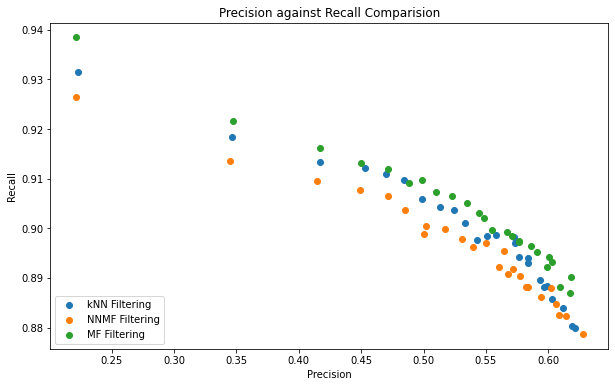

In [135]:
plt.gcf().clear()
plt.figure(figsize=(10,6))
plt.scatter(knn_recall,knn_precision, label='kNN Filtering')
plt.scatter(nmf_recall,nmf_precision, label='NNMF Filtering')
plt.scatter(nmf_biased_recall,nmf_biased_precision, label='MF Filtering')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision against Recall Comparision')
plt.legend(loc="lower left")
plt.show()